# *** Choose your configuration: 0 docker, 1 cloudveneto ***

In [1]:
#0 Docker, 1 CloudVeneto
FIGHTER = 1

In [2]:
# la porta dove vedere i jobs --- METTERE LA PROPRIA QUI ---
SparkUI = 4041

# nicolò 4040
# marco  4041
# francesco 4042
# raffaele  4043

# MASTER 8080 E' PER TUTTI

<span style="font-size: 150%">Porta 8080, voce Running Applications: puoi vedere se qualcuno ci sta lavorando.
<br>
Porta 8080, voce Workers: vedresti core e memoria usata se c'è qualcun'altro.</span>

In [3]:
user = "user_a" # "user_a"  o  "user_b" (B SE SI E' I SECONDI A LAVORARCI)

In [4]:
core = 8 # 8 di 16, lasciare così se si lavora in due

In [5]:
Npartition = 8

# *** Remember to close Spark Session ***

In [6]:
spark.stop()

NameError: name 'spark' is not defined

sudo pkill -u $(whoami) -f "jupyter-notebook"

<hr style="height:4px; background-color:black; border:none;" />

# Creation of the Spark Session and Context

In [7]:
# Standard libraries
import os
import numpy as np
import pandas as pd
from math import ceil
import matplotlib.pyplot as plt

# PySpark core
from pyspark import SparkFiles
from pyspark.sql import SparkSession, DataFrame, Window
from pyspark.sql.types import IntegerType

# PySpark functions
from pyspark.sql.functions import (
    coalesce,
    col, lit, expr, when, count, sum as spark_sum, abs as spark_abs,
    round as spark_round, min as spark_min, max as spark_max, avg as spark_avg,
    first, last, lag, row_number, desc, asc,
    explode, sequence, from_unixtime, to_date, unix_timestamp,
    window, min_by, mode, concat, monotonically_increasing_id
)

In [8]:
if FIGHTER==0:

    spark = SparkSession.builder \
        .master("spark://spark-master:7077") \
        .appName("ProjectDocker") \
        .config("spark.executor.memory", "1000m") \
        .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
        .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false") \
        .getOrCreate()

        # SE NON FUNZIONA TOGLI I DUE CONFIG DI ARROW

        # .config("spark.executor.memory", "1500m")
        # .config("spark.executor.cores", "1")\
        # .config("spark.executor.instances", "12")\
        # .config("spark.cores.max", "12")\
        # .config("spark.default.parallelism", "24")\
        # .config("spark.sql.adaptive.enabled", "true")\

elif FIGHTER==1:

        os.environ["PYSPARK_PYTHON"] = "/opt/miniconda3/bin/python"
        os.environ["PYSPARK_DRIVER_PYTHON"] = "/opt/miniconda3/bin/python"
        
        spark = SparkSession.builder \
            .appName("ProjectCloudVeneto") \
            .master("spark://10.67.22.135:7077") \
            .config("spark.scheduler.mode", "FAIR") \
            .config("spark.scheduler.pool", user) \
            .config("spark.scheduler.allocation.file", "file:///usr/local/spark/conf/fairscheduler.xml") \
            .config("spark.cores.max", core) \
            .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
            .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false") \
            .config("spark.dynamicAllocation.enabled", "false") \
            .config("spark.shuffle.service.enabled", "false") \
            .config("spark.ui.port", SparkUI) \
            .getOrCreate()
    
else : print("Better choose an available fighter, you little bastard.")

sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/01 20:58:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Dataset upload and partition

### General Dataset

In [9]:
if FIGHTER==0:
    df = spark.read.option("header", True).option("inferSchema", True).csv("/ProvePreliminari/SW-106.csv")

elif FIGHTER==1:
    df = spark.read.option("header", True).option("inferSchema", True).csv("file:///mnt/shared/dataset.csv")

else:
    print("Better choose an available fighter, you little bastard")

df = df.repartition(Npartition)

In [10]:
# inspect dataset
df.printSchema()

root
 |-- when: long (nullable = true)
 |-- hwid: string (nullable = true)
 |-- metric: string (nullable = true)
 |-- value: integer (nullable = true)



In [11]:
# inspect dataset
df.show(10, truncate=False)

[Stage 2:=======================================================> (38 + 1) / 39]

+-------------+------+------+-----+
|when         |hwid  |metric|value|
+-------------+------+------+-----+
|1605443202948|SW-065|S50   |0    |
|1605217648678|SW-065|SA11  |0    |
|1605788492021|SW-065|S109  |562  |
|1605112416487|SW-065|S69   |0    |
|1605702429308|SW-065|S171  |1    |
|1605477208178|SW-065|S154  |0    |
|1605258379747|SW-065|SA2   |0    |
|1605812513824|SW-065|P1    |2    |
|1605286852069|SW-065|S45   |0    |
|1605918355920|SW-065|S72   |0    |
+-------------+------+------+-----+
only showing top 10 rows



### Focus on one hardware at time

In [12]:
# convert milliseconds into seconds
df = df.withColumn("when", spark_round(col("when") / 1000).cast(IntegerType()))

In [13]:
hwid_list = df.select("hwid").distinct()
hwid_list.show()

[Stage 7:=============================>                             (4 + 4) / 8]

+------+
|  hwid|
+------+
|SW-088|
|SW-106|
|SW-065|
|SW-115|
+------+



In [14]:
# CHANGE HERE HARDWARE TO ANALYZE
hardware = "SW-106"
df_hw = df  .filter(col("hwid") == hardware)\
            .groupBy("when")\
            .pivot("metric")\
            .agg(first("value"))\
            .withColumn("time", from_unixtime(col("when")))\
            .orderBy("when")

In [15]:
# momentarily persist this dataframe, then we'll unpersist
df_hw = df_hw.persist()

25/08/01 21:00:31 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [16]:
# we trigger persist transformation
df_hw.show(1, truncate=False)

[Stage 42:=============================================>        (169 + 8) / 200]

+----------+----+----+--------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+----+----+----+----+----+---+----+----+----+----+----+----+---+----+----+----+----+----+----+----+----+----+----+----+----+---+---+----+----+----+----+----+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+---+---+---+---+---+---+---+---+---+---+---+---+---+----+----+----+---+---+---+---+---+---+---+---+---+-------------------+
|when      |A5  |A9  |ComError|P1 |P10|P15|P16|P17|P18|P2 |P5 |P6 |P7 |P8 |P9 |S1 |S10|S100|S101|S102|S106|S107|S108|S109|S11|S110|S112|S113|S114|S115|S117|S118|S122|S123|S124|S125|S126|S127|S128|S129|S130|S137|S138|S140|S143|S147|S15|S151|S154|S157|S158|S159|S16|S163|S164|S165|S166|S167|S169|S17|S170|S171|S172|S173|S174|S175|S176|S178|S179|S180|S181|S183|S19|S2 |S

In [17]:
df_hw.printSchema()

root
 |-- when: integer (nullable = true)
 |-- A5: integer (nullable = true)
 |-- A9: integer (nullable = true)
 |-- ComError: integer (nullable = true)
 |-- P1: integer (nullable = true)
 |-- P10: integer (nullable = true)
 |-- P15: integer (nullable = true)
 |-- P16: integer (nullable = true)
 |-- P17: integer (nullable = true)
 |-- P18: integer (nullable = true)
 |-- P2: integer (nullable = true)
 |-- P5: integer (nullable = true)
 |-- P6: integer (nullable = true)
 |-- P7: integer (nullable = true)
 |-- P8: integer (nullable = true)
 |-- P9: integer (nullable = true)
 |-- S1: integer (nullable = true)
 |-- S10: integer (nullable = true)
 |-- S100: integer (nullable = true)
 |-- S101: integer (nullable = true)
 |-- S102: integer (nullable = true)
 |-- S106: integer (nullable = true)
 |-- S107: integer (nullable = true)
 |-- S108: integer (nullable = true)
 |-- S109: integer (nullable = true)
 |-- S11: integer (nullable = true)
 |-- S110: integer (nullable = true)
 |-- S112: integer 

In [18]:
selected_cols = ["when", "time", "S117", "S118", "S169", "S170"]

In [19]:
# show first 5 rows
df_hw.select(*selected_cols).orderBy(col("time").asc()).show(5)

+----------+-------------------+----+----+----+----+
|      when|               time|S117|S118|S169|S170|
+----------+-------------------+----+----+----+----+
|1601510422|2020-10-01 00:00:22|   0|   1|NULL|NULL|
|1601510425|2020-10-01 00:00:25|NULL|NULL|   0|   1|
|1601510453|2020-10-01 00:00:53|   0|   1|NULL|NULL|
|1601510455|2020-10-01 00:00:55|NULL|NULL|   0|   1|
|1601510483|2020-10-01 00:01:23|   0|   1|NULL|NULL|
+----------+-------------------+----+----+----+----+
only showing top 5 rows



In [20]:
# show last 5 rows
df_hw.select(*selected_cols).orderBy(col("time").desc()).limit(5).orderBy(col("time").asc()).show()

+----------+-------------------+----+----+----+----+
|      when|               time|S117|S118|S169|S170|
+----------+-------------------+----+----+----+----+
|1616830056|2021-03-27 07:27:36|NULL|NULL|   0|   0|
|1616830083|2021-03-27 07:28:03|   1|   0|NULL|NULL|
|1616830086|2021-03-27 07:28:06|NULL|NULL|   0|   0|
|1616830114|2021-03-27 07:28:34|   0|   0|NULL|NULL|
|1616830117|2021-03-27 07:28:37|NULL|NULL|   0|   0|
+----------+-------------------+----+----+----+----+



Usefull function to inspect a general dataframe

In [21]:
def inspect(df: DataFrame, sensors: list, start: int, end: int) -> DataFrame:
    """
    Filter a DataFrame by time range and select specified sensor columns.

    Args:
        df:        Input Spark DataFrame with 'when' and 'time' columns.
        sensors:   List of sensor column names to include (e.g., ['S117', 'S118']).
        start:  Start of the time range (Unix timestamp, in seconds).
        end:    End of the time range (Unix timestamp, in seconds).

    Returns:
        Filtered Spark DataFrame with columns ['time', 'when', ...sensors].
    """
    selected_columns = ["when","time"] + sensors

    return (
        df.select(*selected_columns)
          .filter((col("when") >= start) & (col("when") <= end))
    )

In [22]:
inspect(df_hw, sensors=["S117"], start=1601526622, end=1601531000).show(10)

+----------+-------------------+----+
|      when|               time|S117|
+----------+-------------------+----+
|1601526632|2020-10-01 04:30:32|   0|
|1601526639|2020-10-01 04:30:39|NULL|
|1601526662|2020-10-01 04:31:02|   0|
|1601526665|2020-10-01 04:31:05|NULL|
|1601526693|2020-10-01 04:31:33|   0|
|1601526695|2020-10-01 04:31:35|NULL|
|1601526723|2020-10-01 04:32:03|   0|
|1601526850|2020-10-01 04:34:10|   0|
|1601526853|2020-10-01 04:34:13|NULL|
|1601526881|2020-10-01 04:34:41|   0|
+----------+-------------------+----+
only showing top 10 rows



# Timestamp analysis

In [23]:
def compute_time_differences(df, when_col="when", max_collect=1_000_000):
    """
    Computes time differences (Δwhen) between consecutive rows in a DataFrame.

    Args:
        df (DataFrame): Spark DataFrame with a time column (e.g., 'when').
        when_col (str): Name of the time column to compute differences on.
        max_collect (int): Threshold to safely collect diffs to driver.

    Returns:
        rdd_diff (RDD): RDD of differences (current - previous).
    """
    rdd_times = df.select(when_col).rdd.map(lambda row: row[when_col])
    rdd_shifted = rdd_times.zipWithIndex().map(lambda x: (x[1], x[0]))  # (index, time)
    rdd_prev = rdd_shifted.map(lambda x: (x[0] + 1, x[1]))              # shift by +1 index
    rdd_joined = rdd_shifted.join(rdd_prev).sortByKey()
    rdd_diff = rdd_joined.map(lambda x: x[1][0] - x[1][1])

    num_diffs = rdd_diff.count()
    print(f"Number of time differences: {num_diffs}")

    if num_diffs < max_collect:
        return rdd_diff
    else:
        print("Too many differences to collect safely.")
        return None

In [24]:
def time_diff_summary(rdd_diff, spark, top_n=5):
    """
    Summarizes the RDD of time differences into a frequency table and prints top/bottom values.

    Args:
        rdd_diff (RDD): RDD of integer time differences.
        spark (SparkSession): Active Spark session.
        top_n (int): Number of rows to show from top and bottom.

    Returns:
        df_freq (DataFrame): DataFrame with columns ['diff', 'count'].
    """
    if rdd_diff is None:
        print("No differences available to summarize.")
        return None

    df_freq = rdd_diff.map(lambda d: (d, 1)) \
                      .reduceByKey(lambda a, b: a + b) \
                      .toDF(["diff", "count"]) \
                      .orderBy("diff")

    print(f"\n{top_n} smallest time differences:")
    df_freq.show(top_n, truncate=False)

    print(f"\n{top_n} largest time differences:")
    df_freq.orderBy("diff", ascending=False).show(top_n, truncate=False)

    return df_freq

In [25]:
# Compute time differences
rdd_diff = compute_time_differences(df_hw)

# Summarize and print top/bottom time gaps
df_diff_summary = time_diff_summary(rdd_diff, spark)

Number of time differences: 398038



5 smallest time differences:


+----+------+
|diff|count |
+----+------+
|2   |23809 |
|3   |166233|
|4   |5106  |
|5   |464   |
|6   |298   |
+----+------+
only showing top 5 rows


5 largest time differences:


[Stage 111:===================================================> (389 + 6) / 400]

+-------+-----+
|diff   |count|
+-------+-----+
|5003774|1    |
|2066908|1    |
|757864 |1    |
|48451  |1    |
|28598  |1    |
+-------+-----+
only showing top 5 rows



In [26]:
def plot_diff_histogram(differences, min_diff, max_diff, delta):
    
    filtered = [d for d in differences if min_diff <= d <= max_diff]

    bins = int((max_diff - min_diff) / delta)

    plt.figure(figsize=(10, 6))
    plt.hist(filtered, bins=bins, color="steelblue", edgecolor="black")
    plt.title(f"Time Difference Events (range {min_diff} - {max_diff} [s])")
    plt.xlabel("Time difference [s]")
    plt.ylabel("Counts")
    #plt.grid(True)
    plt.show()

In [27]:
diffs = rdd_diff.collect() # check previously the dimension

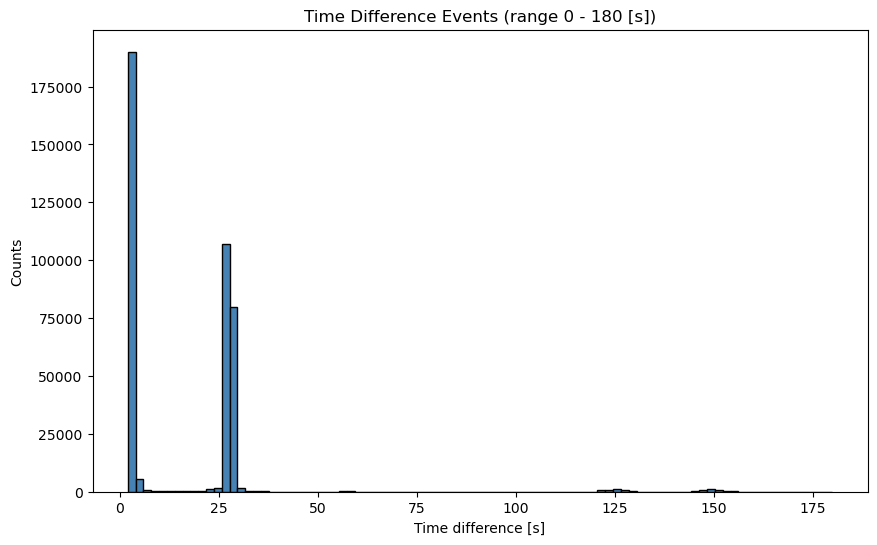

In [28]:
plot_diff_histogram(differences=diffs, min_diff=0, max_diff=180, delta=2)

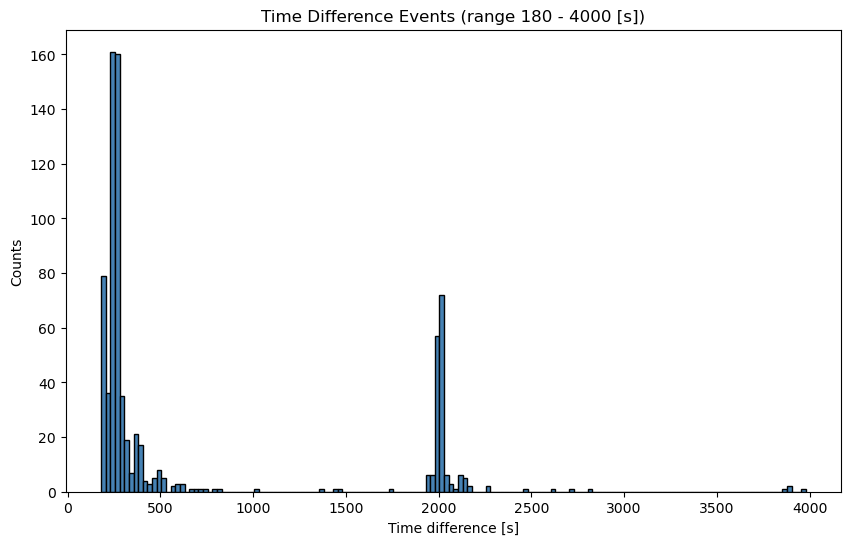

In [29]:
plot_diff_histogram(differences=diffs, min_diff=180, max_diff=4000, delta=25)

# Handling missing data & gaps

### Create final grid

Direi di tenere questa funzione "FillGaps" e continuare ad implementare partendo da questa

In [30]:
frequency = 60 #seconds

In [31]:
def FillGaps(
    df: DataFrame,
    sensors: list = None,
    interval: int = 60,
    modality: str = 'auto',
    fill_null: bool = False
) -> DataFrame:
    """
    Aggregates sensor data into fixed-size time windows and fills missing values using Spark.

    Args:
        df: Spark DataFrame with a 'when' column (UNIX timestamp in seconds).
        sensors: List of sensor column names. If None, inferred from all columns except 'when' and 'time'.
        interval: Window size in seconds.
        modality: Aggregation method: 'mean', 'min', 'max', 'mode', or 'auto'.
        fill_null: If True, fills missing values using forward and backward fill in Spark.

    Returns:
        Aggregated and optionally gap-filled DataFrame, with a `when` column at the center of the window
        and a `window_id` column that uniquely identifies each time window.
    """

    # 1. Infer sensor columns if not provided
    if sensors is None:
        sensors = [c for c in df.columns if c not in ("when", "time")]

    # 2. Add timestamp column
    df_ts = df.withColumn("timestamp", from_unixtime(col("when")).cast("timestamp"))

    # 3. Create time window
    df_windowed = df_ts.withColumn("time_window", window("timestamp", f"{interval} seconds"))

    # 4. Aggregate using selected modality
    if modality == "mode":
        # Special case: MODE needs groupBy and count per window + sensor
        aggs = []
        for s in sensors:
            mode_df = (
                df_windowed.groupBy("time_window", s)
                .agg(count("*").alias("cnt"))
                .withColumn("rank", row_number().over(
                    Window.partitionBy("time_window").orderBy(desc("cnt"))
                ))
                .filter(col("rank") == 1)
                .select("time_window", col(s).alias(s))
            )
            if not aggs:
                result_df = mode_df
            else:
                result_df = result_df.join(mode_df, on="time_window", how="outer")
    else:
        aggs = []
        for s in sensors:
            if modality == "mean":
                agg_func = spark_avg(col(s)).alias(s)
            elif modality == "min":
                agg_func = spark_min(col(s)).alias(s)
            elif modality == "max":
                agg_func = spark_max(col(s)).alias(s)
            elif modality == "auto":
                stats = df.selectExpr(f"min({s}) as min", f"max({s}) as max").first()
                is_binary = stats["min"] is not None and stats["max"] is not None and 0 <= stats["min"] and stats["max"] <= 1
                if s in ["A5", "A9"] or is_binary:
                    agg_func = spark_max(col(s)).alias(s)
                else:
                    agg_func = spark_avg(col(s)).alias(s)
            else:
                raise ValueError(f"Unsupported modality: {modality}")
            aggs.append(agg_func)

        result_df = (
            df_windowed
            .groupBy("time_window")
            .agg(*aggs)
        )

    # 5. Add window_start, window_end, and 'when' as center of window
    result_df = (
        result_df
        .withColumn("window_start", col("time_window.start"))
        .withColumn("window_end", col("time_window.end"))
        .withColumn("when", expr("unix_timestamp(window_start) + int((unix_timestamp(window_end) - unix_timestamp(window_start)) / 2)"))
        .drop("time_window")
        .orderBy("when")
    )

    # 6. Fill nulls if requested using Spark-native ffill + bfill
    if fill_null:
        w_forward = Window.orderBy("when").rowsBetween(Window.unboundedPreceding, 0)
        w_backward = Window.orderBy("when").rowsBetween(0, Window.unboundedFollowing)
        for s in sensors:
            result_df = result_df.withColumn(s, last(col(s), ignorenulls=True).over(w_forward))
            result_df = result_df.withColumn(s, first(col(s), ignorenulls=True).over(w_backward))

    # 7. Add window_id as progressive row number
    result_df = result_df.withColumn("window_id", monotonically_increasing_id())

    return result_df.select(["window_id", "when", "window_start", "window_end"] + sensors)

    # 6. Optionally fill nulls using Pandas (costly)
    # if fill_null:
    #     pandas_df = result_df.toPandas()
    #     pandas_df = pandas_df.ffill().bfill()
    #     return spark.createDataFrame(pandas_df)
    # else:
    #     return result_df

Already added conversion of A5 and A9 sensors, and overheating control function.

In [32]:
def extract_alarm_bits(df: DataFrame, columns=["A5", "A9"], bits=[6, 7, 8]) -> DataFrame:
    """
    Extracts specific bits (1-indexed, left to right) from the given integer alarm columns
    and adds them as new columns in the DataFrame.

    Args:
        df: Input Spark DataFrame.
        columns: List of alarm column names (e.g., ["A5", "A9"]).
        bits: List of bit positions to extract (left-to-right, 1-based index).

    Returns:
        DataFrame with additional columns like "6-A5", "7-A9", etc.
    """
    for col_name in columns:
        for bit in bits:
            # Convert left-to-right to right-to-left (bit 1 is MSB → position 15)
            bit_from_right = 16 - bit
            df = df.withColumn(
                f"{bit}-{col_name}",
                ((col(col_name).bitwiseAND(1 << bit_from_right)) > 0).cast("int")
            )
    return df

In [33]:
def add_overheating_flag(df: DataFrame) -> DataFrame:
    """
    Adds a binary column 'overheating' which is 1 if any of bits 6, 7, or 8 of A5 or A9 is 1.

    Args:
        df: Spark DataFrame with bit columns already extracted.

    Returns:
        DataFrame with 'overheating' column added.
    """
    overheating_bits = [f"{b}-{s}" for s in ["A5", "A9"] for b in [6, 7, 8]]
    condition = sum([col(c) for c in overheating_bits]) > 0
    return df.withColumn("overheating", when(condition, 1).otherwise(0))

In [34]:
# %%time

# #2° MODALITA' USO FUNZIONE FillGaps
# #Doesn't seem to be particularly dependent on the number of metrics (9 seconds with 1, 13 seconds with 15)
# sensors=['S117', 'S118',  'S169', 'S170', 'S41', 'ComError']#, 'A5', 'A9', 'P18', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1']
# GridDF = FillGaps(df_hw, sensors=sensors, modality="min", interval=60)
# GridDF.show(10, truncate = False)

In [35]:
%%time

#1° MODALITA' USO FUNZIONE FillGaps
# Fill sensor gaps
df_grid = FillGaps(df_hw, interval=frequency, modality="auto", fill_null=False)

# Extract bits from alarms
df_grid = extract_alarm_bits(df_grid, columns=["A5", "A9"], bits=[6, 7, 8])

# Add 'overheating' column
# --- IMPLEMENTATA GIA (E' RICHIESTA PIU' AVANTI) ORA NON SERVE
# df_final = add_overheating_flag(df_final)

# Now persist the result
df_final = df_grid.persist()

# Trigger persist
df_final.show(1, truncate = False)

# Unpersist original dataframe
# --- PER IL MOMENTO DIREI DI TENERLO CON IL PERSIST CHE E' PRATICO PER LA FASE DI SVILUPPO PER RICONTROLLARE LE COSE SUL DATAFRAME ORIGINARIO
# df_hw.unpersist()

+---------+----------+-------------------+-------------------+----+----+--------+---+-----+---+-----+-----+-----+---+-----+-----+-----+-----+-----+---+----+----+-----+-----+----+-----+----+-----+---+----+----+----+----+----+----+----+-----+----+-----+----+----+----+----+-----+----+-----+----+----+-----+-----+---+----+----+----+-----+-----+---+----+-----+----+-----+----+----+---+----+----+----+----+----+----+----+-----+----+-------+----+----+---+---+------+------+------+------+------+------+---+----+---+---+---+-----+-----+----+-----+---+---+---+-----+-----+---+---+---+---+---+---+---+---+-----+---+---+---+---+------+----+-----+---+---+-----+----+----+-----+---+-----+----+----+---+----+----+----+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+
|window_id|when      |window_start       |window_end         |A5  |A9  |ComError|P1 |P10  |P15|P16  |P17  |P18  |P2 |P5   |P6   |P7   |P8   |P9   |S1 |S10 |S100|S101 |S102 |S106|S107 |S108|S109 |S11|S110|S112|S113|S114|S115|S117|

In [36]:
df_final.select("window_id","when","window_start","window_end","S110","S112","S113","S114","S115","S117","S118","S122","A9","8-A9").show(30, truncate = False)

+---------+----------+-------------------+-------------------+----+----+----+----+----+----+----+-----+----+----+
|window_id|when      |window_start       |window_end         |S110|S112|S113|S114|S115|S117|S118|S122 |A9  |8-A9|
+---------+----------+-------------------+-------------------+----+----+----+----+----+----+----+-----+----+----+
|0        |1601510430|2020-10-01 00:00:00|2020-10-01 00:01:00|0   |1   |1   |0   |0   |0   |1   |410.0|NULL|NULL|
|1        |1601510490|2020-10-01 00:01:00|2020-10-01 00:02:00|0   |1   |1   |0   |0   |0   |1   |406.5|NULL|NULL|
|2        |1601510550|2020-10-01 00:02:00|2020-10-01 00:03:00|0   |1   |1   |0   |0   |0   |1   |409.0|NULL|NULL|
|3        |1601510610|2020-10-01 00:03:00|2020-10-01 00:04:00|0   |1   |1   |0   |0   |0   |1   |406.5|NULL|NULL|
|4        |1601510670|2020-10-01 00:04:00|2020-10-01 00:05:00|0   |1   |1   |0   |0   |0   |1   |406.5|NULL|NULL|
|5        |1601510730|2020-10-01 00:05:00|2020-10-01 00:06:00|0   |1   |1   |0   |0   |0

In [37]:
#inspect(df_hw, sensors=["S110","S112","S113","S114","S115","S117","S118","S122","A9"], start=1601510400, end=1601512550).show(200)

### Block Structure

In [38]:
#Given the dataset, creates another column with the block id given the max_interval between two data points
def BuildBlocks(df, max_interval):

    #Computes a new column with the time difference between next timestamp
    w = Window.partitionBy(lit(1)).orderBy("when")

    df = df.withColumn("Prev_TimeStamp", lag("when").over(w))
    df = df.withColumn("TimeDiff_s", col("when") - col("Prev_TimeStamp"))

    #Handle the first NULL value 
    df = df.withColumn("TimeDiff_s", coalesce(col("TimeDiff_s"), lit(60)))

    #Define blocks_id
    df = df.withColumn("CheckNewBlock", when(col("TimeDiff_s") > max_interval, 1).otherwise(0))
    df = df.withColumn("BlockID", spark_sum("CheckNewBlock").over(w))

    return df
    

In [39]:
df_final = BuildBlocks(df_final, max_interval = 300)
df_final.select("window_id","when","window_start","window_end", "TimeDiff_s", "BlockID").show(30)

#A questo punto sarebbe meglio fare il persist

+---------+----------+-------------------+-------------------+----------+-------+
|window_id|      when|       window_start|         window_end|TimeDiff_s|BlockID|
+---------+----------+-------------------+-------------------+----------+-------+
|        0|1601510430|2020-10-01 00:00:00|2020-10-01 00:01:00|        60|      0|
|        1|1601510490|2020-10-01 00:01:00|2020-10-01 00:02:00|        60|      0|
|        2|1601510550|2020-10-01 00:02:00|2020-10-01 00:03:00|        60|      0|
|        3|1601510610|2020-10-01 00:03:00|2020-10-01 00:04:00|        60|      0|
|        4|1601510670|2020-10-01 00:04:00|2020-10-01 00:05:00|        60|      0|
|        5|1601510730|2020-10-01 00:05:00|2020-10-01 00:06:00|        60|      0|
|        6|1601510790|2020-10-01 00:06:00|2020-10-01 00:07:00|        60|      0|
|        7|1601510850|2020-10-01 00:07:00|2020-10-01 00:08:00|        60|      0|
|        8|1601510910|2020-10-01 00:08:00|2020-10-01 00:09:00|        60|      0|
|        9|16015

In [40]:
df_final.groupBy("BlockID").count().orderBy("BlockID").show(100)

+-------+-----+
|BlockID|count|
+-------+-----+
|      0|  204|
|      1|   16|
|      2|   42|
|      3|  104|
|      4|  126|
|      5|  317|
|      6|  100|
|      7|  518|
|      8|  397|
|      9|   54|
|     10|  264|
|     11|   71|
|     12|   19|
|     13|   99|
|     14|  232|
|     15|  320|
|     16|   12|
|     17|   88|
|     18|  562|
|     19|  196|
|     20|   48|
|     21|  255|
|     22|   51|
|     23| 1580|
|     24|   70|
|     25|  280|
|     26|   83|
|     27|  119|
|     28|   72|
|     29|   27|
|     30|   67|
|     31|  204|
|     32|   68|
|     33|  120|
|     34|  238|
|     35|   98|
|     36|  195|
|     37|  119|
|     38|  165|
|     39|   96|
|     40|  109|
|     41|    4|
|     42|  151|
|     43|   62|
|     44|  106|
|     45|   98|
|     46|  938|
|     47|  395|
|     48|  245|
|     49|   36|
|     50|  174|
|     51|  169|
|     52|  178|
|     53|  189|
|     54|   78|
|     55|   33|
|     56|  211|
|     57|  295|
|     58|  609|
|     59

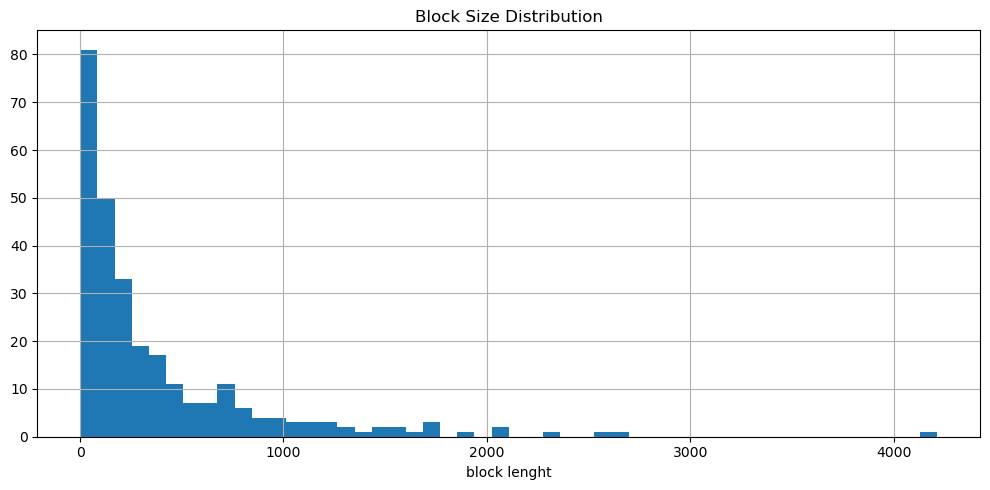

In [41]:
Dist = df_final.groupBy("BlockID").count().orderBy("BlockID")

data = Dist.toPandas()
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(data['count'], bins = 50)
plt.xlabel("block lenght")
#plt.ylabel("Number of Rows in Block")
plt.title("Block Size Distribution")
plt.grid(True)
plt.tight_layout()
plt.show()

### Anomaly detection

In [42]:
def detect_switch_anomalies(df, sensors, window_minutes=10, switch_threshold=5):
    """
    Detects frequent switching for binary sensors, partitioned by day to avoid single-node pressure.
    """

    # Extract day (or hour) from timestamp to partition
    df = df.withColumn("day", to_date(col('window_start')))

    # Lag to get previous value within each partition --- OTHERWISE IT MOVES ALL IN THE SAME PARTITION
    w_lag = Window.partitionBy("day").orderBy("when")
    lagged_columns = [lag(col(s)).over(w_lag) for s in sensors] # per ogni sensore prendo le righe shiftate di 1 all'indietro
    lag_names      = [f"lagged_{s}" for s in sensors]
    
    df_lagged = df.withColumns(dict(zip(lag_names, lagged_columns)))

    # Detect change 0→1 or 1→0
    didSwitch   = [when((col(f"lagged_{s}") != col(s)), 1).otherwise(0) for s in sensors] # per ogni sensore verifico se il valore è cambiato rispetto al precedente 
    switch_names = [f"switch_{s}" for s in sensors]
    
    df_changes = df_lagged.withColumns(dict(zip(switch_names, didSwitch)))

    # Rolling window over time with partition
    w_time = Window.partitionBy("day").orderBy("when").rangeBetween(-window_minutes * 60, 0)
    change_counts = [spark_sum(f"switch_{s}").over(w_time) for s in sensors]
    counts_names  = [f"change_count_{s}" for s in sensors]
    
    df_windowed = df_changes.withColumns(dict(zip(counts_names, change_counts)))

    # Flag anomaly
    anomalies       = [col(f"change_count_{s}") > switch_threshold for s in sensors]
    anomalies_names = [f"{s}_anomaly" for s in sensors]
    
    df_anomaly = df_windowed \
    .withColumns(dict(zip(anomalies_names, anomalies))) \
    .select("BlockID","window_id","window_start",*sensors,*anomalies_names)
    #.drop(*lag_names, *switch_names, *counts_names, "day", "when")

    return df_anomaly

def detect_switch_anomalies_2(df, sensors, window_minutes=10, switch_threshold=5):
    """
    Crea un dataframe che contiene una flag per le anomalie di ogni sensore ogni window_minutes 
    NB: siccome la grid è spaziata di 1 minuto, window_minutes deve essere > 1 per avere senso
    """

    # Extract day (or hour) from timestamp to partition
    df = df \
        .select('when', *sensors, 'window_start', 'window_end') \
        .withColumn("day", to_date(col('window_start')))

    # Lag to get previous value within each partition --- OTHERWISE IT MOVES ALL IN THE SAME PARTITION 
    w_lag = Window.partitionBy("day").orderBy("when")
    lagged_columns = [lag(col(s)).over(w_lag) for s in sensors] # per ogni sensore prendo le righe shiftate di 1 all'indietro
    lag_names      = [f"lagged_{s}" for s in sensors]
    
    df_lagged = df.withColumns(dict(zip(lag_names, lagged_columns)))

    # Detect change 0→1 or 1→0
    didSwitch   = [when((col(f"lagged_{s}") != col(s)), 1).otherwise(0) for s in sensors] # per ogni sensore verifico se il valore è cambiato rispetto al precedente 
    switch_names = [f"switch_{s}" for s in sensors]
    
    df_changes = df_lagged.withColumns(dict(zip(switch_names, didSwitch)))

    # Rolling window over time with partition
    # Raffaele: così rischiamo di contare più volte la stessa anomalia.
     '''
    w_time = Window.partitionBy("day").orderBy("when").rangeBetween(-window_minutes * 60, 0)
    change_counts = [spark_sum(f"switch_{s}").over(w_time) for s in sensors]
    counts_names  = [f"change_count_{s}" for s in sensors]
    
    df_windowed = df_changes.withColumns(dict(zip(counts_names, change_counts)))
     '''
    w_group = Window.orderBy('when')
    w_count = Window.partitionBy('groupId')
    
    df_switch_group = (
        df_changes \
        .withColumn('switch_group', when(lag(col('switch_S117')) != col('switch_S117'), 1).otherwise(0)) \
        .withColumn('groupId', spark_sum('switch_group').over(w_group)) \
        .withColumn('')
    )

    # Flag anomaly
    anomalies       = [col(f"change_count_{s}") > switch_threshold for s in sensors]
    anomalies_names = [f"{s}_anomaly" for s in sensors]
    
    df_anomaly = df_windowed \
    .withColumns(dict(zip(anomalies_names, anomalies))) \
    .drop(*lag_names, *switch_names, *counts_names, "day", "window_idx")

    return df_anomaly

In [43]:
%%time

sensors = ['S117', 'S118', 'S169', 'S170']

anomalies = detect_switch_anomalies(
  df_final,
  sensors=[s for s in sensors],
  window_minutes=60,
  switch_threshold=6
)

# Almeno un motore abbia anomalia per dire di aver anomalia
anomalies = anomalies.withColumn(
    "has_anomaly",
    when(
        col("S117_anomaly") | col("S118_anomaly") | col("S169_anomaly") | col("S170_anomaly"),
        1
    ).otherwise(0)
)

# Per confronto vediamo se le anomalie del S117 corrispondono a quelle del metodo di Marco:
anomalies \
    .filter("S117_anomaly") \
    .show(truncate=False)

# Questo non va ancora
#filters = [col(f"mode_{s}_anomaly") for s in sensors] 
#total_filter = filters[0]
#for i in range(1, len(filters)):
#    total_filter = total_filter & filters[i]


+-------+------------+-------------------+----+----+----+----+------------+------------+------------+------------+-----------+
|BlockID|window_id   |window_start       |S117|S118|S169|S170|S117_anomaly|S118_anomaly|S169_anomaly|S170_anomaly|has_anomaly|
+-------+------------+-------------------+----+----+----+----+------------+------------+------------+------------+-----------+
|77     |292057776595|2020-10-16 20:11:00|1   |1   |0   |1   |true        |false       |false       |false       |1          |
|77     |292057776596|2020-10-16 20:12:00|1   |1   |0   |1   |true        |false       |false       |false       |1          |
|77     |300647710729|2020-10-16 20:51:00|1   |1   |1   |0   |true        |false       |false       |false       |1          |
|77     |300647710730|2020-10-16 20:52:00|1   |1   |1   |0   |true        |false       |false       |false       |1          |
|77     |300647710731|2020-10-16 20:53:00|1   |1   |1   |0   |true        |false       |false       |false     

In [44]:
def plot_anomaly_hist(df, sensors, time_start, time_end):
    '''
    Plotta il numero di anomalie al giorno per ogni sensore, nell'arco di tempo [time_start, time_end]
    '''

    casts = [col(f'{s}_anomaly').cast('Int') for s in sensors] # per convertire i booleani in mode_S_anomaly in 0/1 
    aggs = [spark_sum(col(f'{s}_anomaly')).alias(f'anomaly_count_{s}') for s in sensors] # per contare le anomalie ogni giorno

    new_df = df \
    .select('window_start', *[f"{s}_anomaly" for s in sensors]) \
    .filter(unix_timestamp(col("window_start")).between(time_start, time_end)) \
    .withColumn('day', to_date(col('window_start'))) \
    .withColumns(dict(zip([f'{s}_anomaly' for s in sensors], casts))) \
    .groupBy('day').agg(*aggs) \
    .orderBy('day')

    n_sensors = len(sensors)
    fig, axes = plt.subplots(ceil(n_sensors/2), 2, figsize=(20, 5))
    days = new_df.select('day').rdd.flatMap(lambda x: x).collect()
    for i in range(n_sensors):
        counts = new_df.select(f'anomaly_count_{sensors[i]}').rdd.flatMap(lambda x: x).collect()
        idx = i if n_sensors <= 2 else (i//2, i%2)
        axes[idx].bar(days, counts)
        axes[idx].set_title(f'anomaly_count_{sensors[i]}')
        axes[idx].set(xlabel="day", ylabel="counts")
        #print(sensors[i], counts)
    fig.tight_layout()
  

CPU times: user 215 ms, sys: 7.35 ms, total: 223 ms
Wall time: 5.24 s


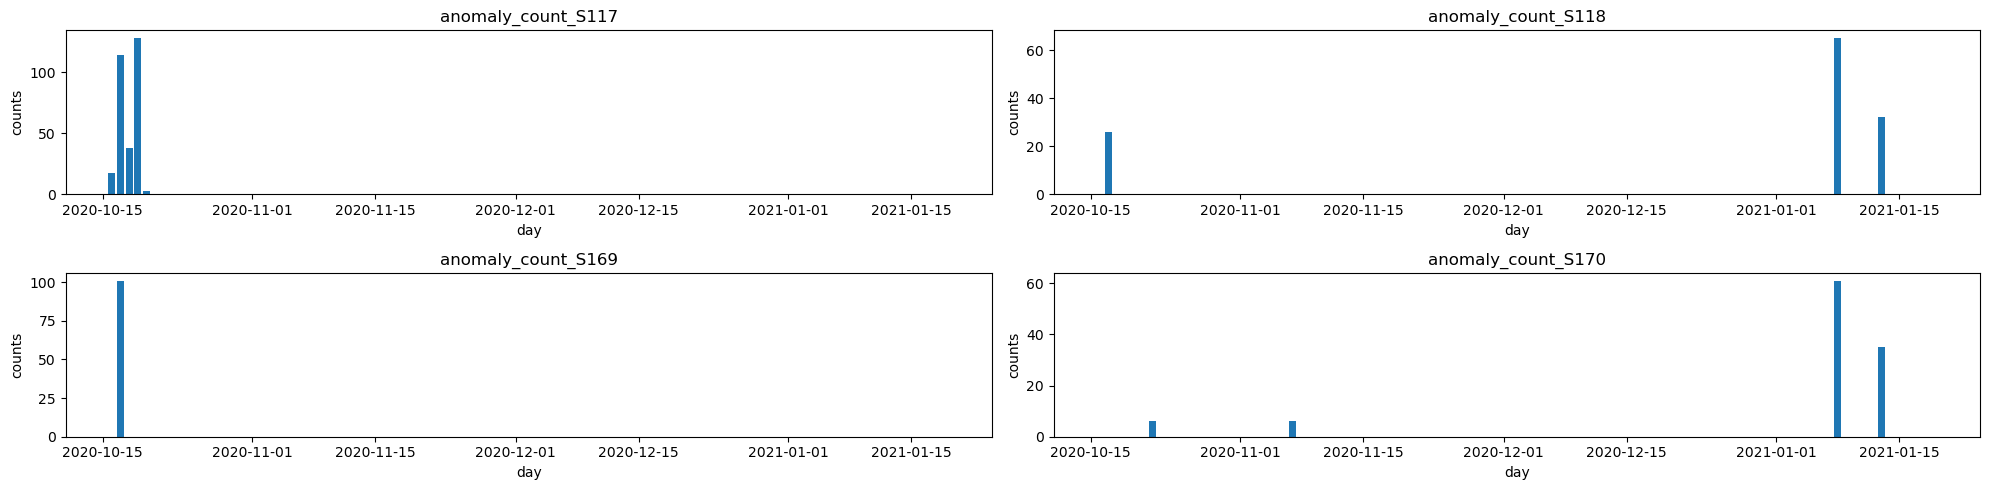

In [45]:
%%time
plot_anomaly_hist(anomalies, ['S117', 'S118', 'S169', 'S170'], 1602879000, 1602879000+10000000)  

In [46]:
df_final.show(1)

[Stage 1944:>                                                       (0 + 1) / 1]

+---------+----------+-------------------+-------------------+----+----+--------+---+-----+---+-----+-----+-----+---+-----+-----+-----+-----+-----+---+----+----+-----+-----+----+-----+----+-----+---+----+----+----+----+----+----+----+-----+----+-----+----+----+----+----+-----+----+-----+----+----+-----+-----+---+----+----+----+-----+-----+---+----+-----+----+-----+----+----+---+----+----+----+----+----+----+----+-----+----+-------+----+----+---+---+------+------+------+------+------+------+---+----+---+---+---+-----+-----+----+-----+---+---+---+-----+-----+---+---+---+---+---+---+---+---+-----+---+---+---+---+------+----+-----+---+---+-----+----+----+-----+---+-----+----+----+---+----+----+----+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+--------------+----------+-------------+-------+
|window_id|      when|       window_start|         window_end|  A5|  A9|ComError| P1|  P10|P15|  P16|  P17|  P18| P2|   P5|   P6|   P7|   P8|   P9| S1| S10|S100| S101| S102|S106| S1

### Correlations

In [47]:
df_corr = df_final.join(
    anomalies.select("window_id", "has_anomaly"), 
    on="window_id", 
    how="left"
).fillna(0, subset=["has_anomaly"])  # riempiamo i null con 0 = no anomaly

In [48]:
variables_of_interest = ["P1", "P10", "P18", "ComError", "S1", "S2", "S3", "S5", "S9", "S10"]

In [49]:
df_pandas = df_corr.select(["has_anomaly"] + variables_of_interest).toPandas()
correlation_matrix = df_pandas.corr(numeric_only=True)

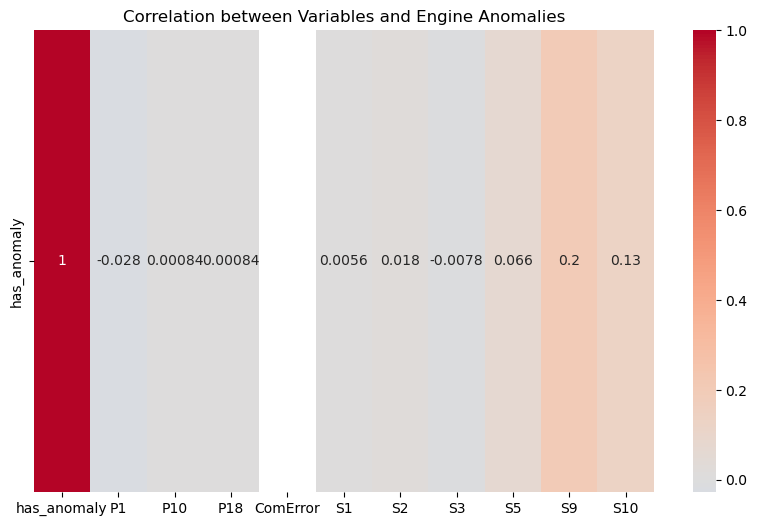

In [50]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.heatmap(
    correlation_matrix[["has_anomaly"]].T,  # solo le correlazioni con la colonna target
    annot=True,
    cmap="coolwarm",
    center=0
)
plt.title("Correlation between Variables and Engine Anomalies")
plt.show()


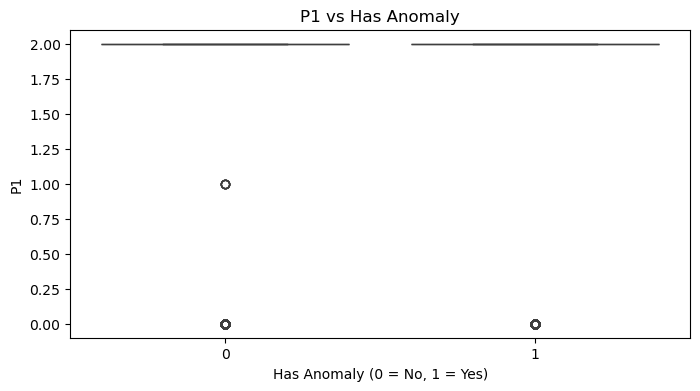

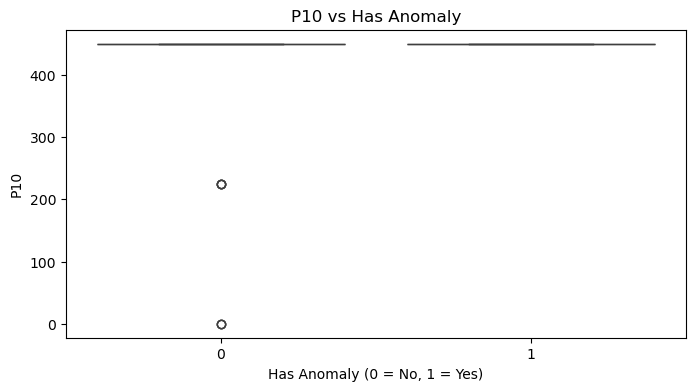

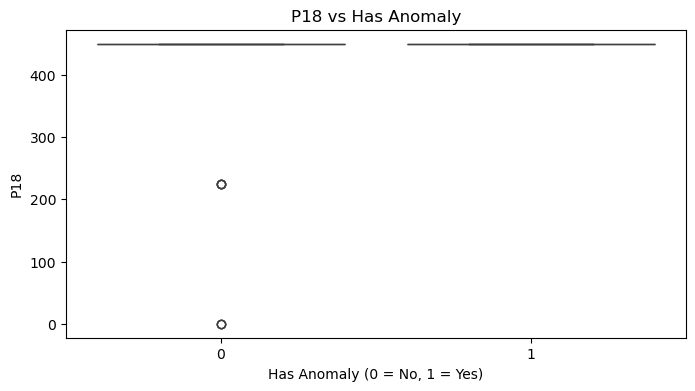

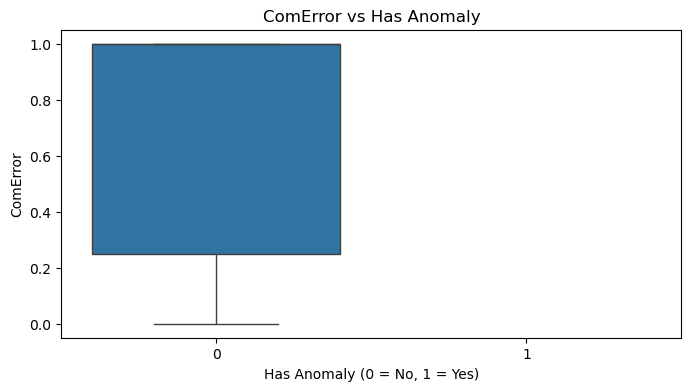

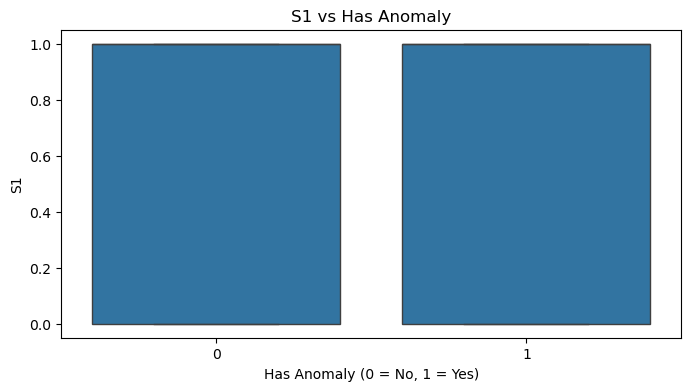

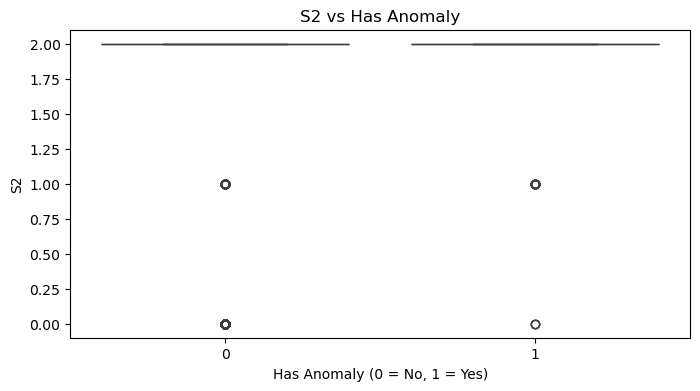

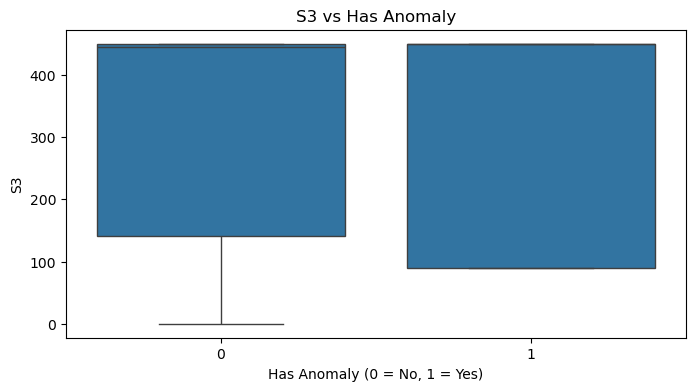

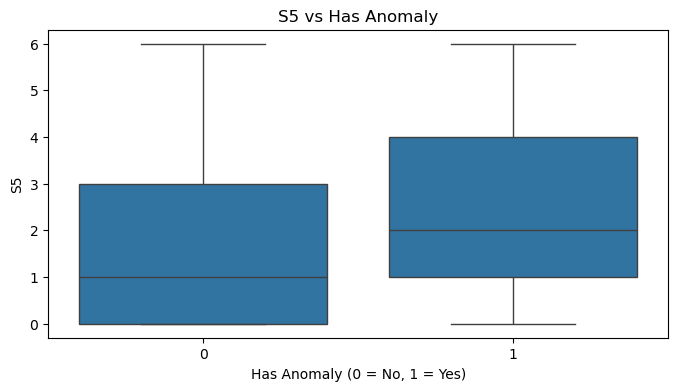

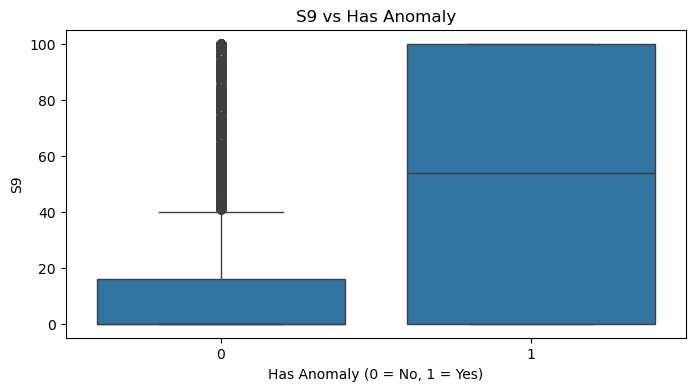

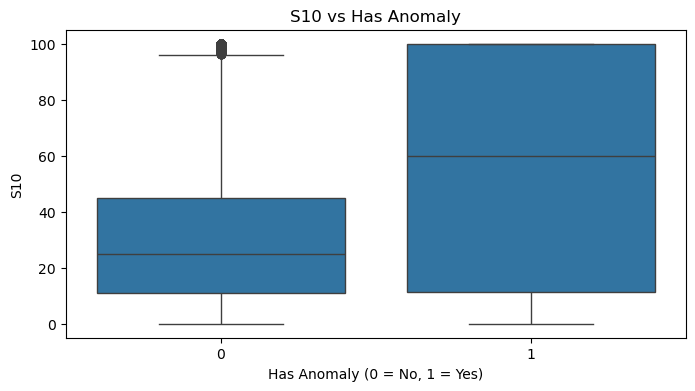

In [51]:
import seaborn as sns

for var in variables_of_interest:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df_pandas, x="has_anomaly", y=var)
    plt.title(f"{var} vs Has Anomaly")
    plt.xlabel("Has Anomaly (0 = No, 1 = Yes)")
    plt.ylabel(var)
    plt.show()

# <hr style="height:4px; background-color:black; border:none;" />

### Block structure

In [27]:
def build_blocks(df_final: DataFrame, frequency: int) -> DataFrame:
    """
    Build blocks using existing window_start for partitioning.
    
    Args:
        df_final: Input Spark DataFrame with 'when' and 'window_start' columns.
        frequency: Maximum allowed time gap in seconds.
    Returns:
        DataFrame with columns: 'window_id', 'block_id'.
    """
    # 1) Extract date from existing window_start column for partitioning
    df_with_day = df_final.withColumn("day", to_date(col("window_start")))
    
    # 2) Window partitioned by day, ordered by when
    window_spec = Window.partitionBy("day").orderBy("when")
    
    # 3) Compute gap to previous timestamp within each day
    df_with_gap = (df_with_day
        .withColumn("prev_when", lag("when", 1).over(window_spec))
        .withColumn("gap", col("when") - col("prev_when"))
    )
    
    # 4) Flag start of new block
    df_with_flag = df_with_gap.withColumn(
        "is_new_block",
        when((col("prev_when").isNull()) | (col("gap") > frequency), 1).otherwise(0)
    )
    
    # 5) Create daily block_id with partitioned window
    df_with_daily_blocks = df_with_flag.withColumn(
        "daily_block_id",
        spark_sum("is_new_block").over(window_spec)
    )
    
    # 6) Create global block_id - get max blocks per day
    daily_max = (df_with_daily_blocks
        .groupBy("day")
        .agg(spark_max("daily_block_id").alias("max_block"))
    )
    
    # 7) Calculate day offsets with partitioned window
    day_window = Window.orderBy("day")
    daily_offsets = (daily_max
        .withColumn("prev_max", lag("max_block", 1).over(day_window))
        .withColumn("day_offset", 
            spark_sum(when(col("prev_max").isNull(), 0).otherwise(col("prev_max"))).over(day_window))
        .fillna(0, subset=["day_offset"])
        .select("day", "day_offset")
    )
    
    # 8) Join and create final block_id
    result = (df_with_daily_blocks
        .join(daily_offsets, "day")
        .withColumn("block_id", col("daily_block_id") + col("day_offset") - 1)
        .select("window_id", "block_id")
        .orderBy("when")  # Final sort by time
    )
    
    return result

In [28]:
df_blocks = build_blocks(df_final, frequency=frequency)

In [29]:
df_blocks.show(30)

25/08/01 20:32:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/01 20:32:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/01 20:32:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/01 20:32:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/01 20:32:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/01 20:32:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/01 2

+---------+--------+
|window_id|block_id|
+---------+--------+
|        0|       0|
|        1|       0|
|        2|       0|
|        3|       0|
|        4|       0|
|        5|       0|
|        6|       0|
|        7|       0|
|        8|       0|
|        9|       0|
|       10|       0|
|       11|       0|
|       12|       0|
|       13|       1|
|       14|       1|
|       15|       1|
|       16|       2|
|       17|       2|
|       18|       2|
|       19|       2|
|       20|       2|
|       21|       3|
|       22|       3|
|       23|       4|
|       24|       4|
|       25|       4|
|       26|       4|
|       27|       5|
|       28|       5|
|       29|       5|
+---------+--------+
only showing top 30 rows



In [30]:
df_final.join(df_blocks, on="window_id", how="left").orderBy("window_id").show(1)

25/08/01 20:32:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/01 20:32:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/01 20:32:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/01 20:32:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/01 20:32:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/01 20:32:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/01 2

+---------+----------+-------------------+-------------------+----+----+--------+---+-----+---+-----+-----+-----+---+-----+-----+-----+-----+-----+---+----+----+-----+-----+----+-----+----+-----+---+----+----+----+----+----+----+----+-----+----+-----+----+----+----+----+-----+----+-----+----+----+-----+-----+---+----+----+----+-----+-----+---+----+-----+----+-----+----+----+---+----+----+----+----+----+----+----+-----+----+-------+----+----+---+---+------+------+------+------+------+------+---+----+---+---+---+-----+-----+----+-----+---+---+---+-----+-----+---+---+---+---+---+---+---+---+-----+---+---+---+---+------+----+-----+---+---+-----+----+----+-----+---+-----+----+----+---+----+----+----+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+--------+
|window_id|      when|       window_start|         window_end|  A5|  A9|ComError| P1|  P10|P15|  P16|  P17|  P18| P2|   P5|   P6|   P7|   P8|   P9| S1| S10|S100| S101| S102|S106| S107|S108| S109|S11|S110|S112|S113|S114|S

In [31]:
df_block_duration = (
    df_blocks.groupBy("block_id")
    .count()
    .withColumn("duration_minutes", (col("count") * lit(frequency)) / 60)
    .drop("count")
    .orderBy("block_id")
)

In [32]:
df_block_duration.show(30,truncate=False)

25/08/01 20:32:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/01 20:32:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/01 20:32:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/01 20:32:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/01 20:32:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/01 20:32:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/01 2

+--------+----------------+
|block_id|duration_minutes|
+--------+----------------+
|0       |13.0            |
|1       |3.0             |
|2       |5.0             |
|3       |2.0             |
|4       |4.0             |
|5       |7.0             |
|6       |4.0             |
|7       |41.0            |
|8       |20.0            |
|9       |2.0             |
|10      |9.0             |
|11      |2.0             |
|12      |6.0             |
|13      |6.0             |
|14      |11.0            |
|15      |16.0            |
|16      |10.0            |
|17      |7.0             |
|18      |11.0            |
|19      |6.0             |
|20      |19.0            |
|21      |9.0             |
|22      |7.0             |
|23      |19.0            |
|24      |3.0             |
|25      |2.0             |
|26      |18.0            |
|27      |4.0             |
|28      |10.0            |
|29      |4.0             |
+--------+----------------+
only showing top 30 rows



In [33]:
df_block_stats = df_block_duration.groupBy(col("duration_minutes").alias("block_length")) \
    .agg(count("*").alias("block_count")).orderBy("block_length")
df_block_stats.show()

25/08/01 20:32:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/01 20:32:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/01 20:32:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/01 20:32:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/01 20:32:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/01 20:32:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/01 2

+------------+-----------+
|block_length|block_count|
+------------+-----------+
|         1.0|        446|
|         2.0|        576|
|         3.0|        471|
|         4.0|        464|
|         5.0|        454|
|         6.0|        394|
|         7.0|        378|
|         8.0|        389|
|         9.0|        351|
|        10.0|        310|
|        11.0|        250|
|        12.0|        248|
|        13.0|        218|
|        14.0|        215|
|        15.0|        204|
|        16.0|        187|
|        17.0|        156|
|        18.0|        164|
|        19.0|        145|
|        20.0|        115|
+------------+-----------+
only showing top 20 rows



In [34]:
def plot_diff_histogram(df_block_stats, min_length=1, max_length=100, step=1):
    """
    Plot a histogram of contiguous block lengths.

    Args:
      df_block_stats: Spark DataFrame with ['block_length','block_count']
      min_length:     smallest block_length to include
      max_length:     largest block_length to include
      step:           bar width
    """
    pdf = (
        df_block_stats
        .filter((col("block_length") >= min_length) &
                (col("block_length") <= max_length))
        .orderBy("block_length")
        .toPandas()
    )

    if pdf.empty:
        print("No blocks in the specified range.")
        return

    plt.figure(figsize=(10,5))
    plt.bar(pdf["block_length"], pdf["block_count"], width=step, align="center")
    plt.xlabel("Block Length")
    plt.ylabel("Number of Blocks")
    plt.title("Histogram of Contiguous Block Lengths")
    plt.grid(True)
    plt.xlim(min_length, max_length)
    plt.show()

25/08/01 20:33:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/01 20:33:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/01 20:33:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/01 20:33:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/01 20:33:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/01 20:33:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/01 2

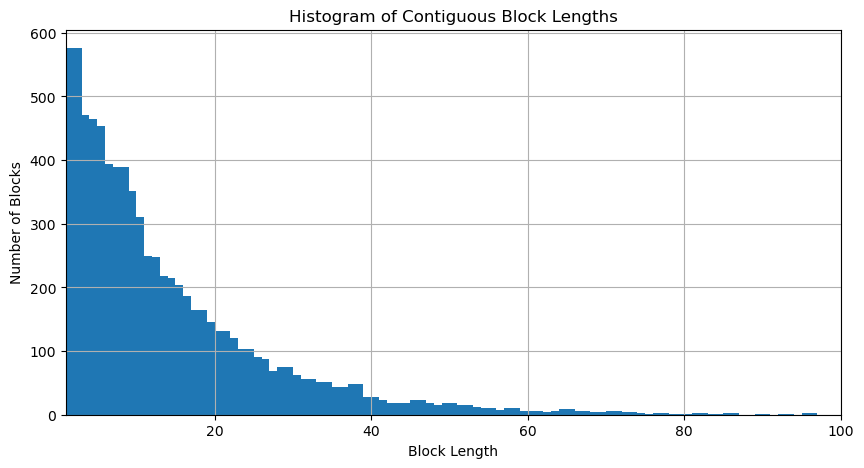

In [35]:
plot_diff_histogram(df_block_stats, min_length=1, max_length=100, step=2)

### Su solo una colonna (metodo nearest) FUNZIONANTE

In [21]:
def resample_sensor_simple(
    df_hard: DataFrame,
    sensor: str,
    interval: int = 60
) -> DataFrame:
    """
    Resample a single sensor column to regular intervals using the nearest non-null value.

    Args:
        df_hard:   Spark DataFrame with columns ['when', sensor].
        sensor:    Name of the sensor column (e.g., 'S117').
        interval:  Resample interval in seconds.

    Returns:
        Resampled DataFrame with ['when', sensor, 'time'], using only non-null nearest values.
    """
    spark = df_hard.sparkSession
    half = interval / 2

    # 1. Create target timestamp grid
    bounds = df_hard.selectExpr("min(when) as min_t", "max(when) as max_t").first()
    min_t, max_t = bounds.min_t, bounds.max_t

    grid_df = (
        spark.range(1)
             .selectExpr(f"sequence({min_t}, {max_t}, {interval}) as times")
             .select(explode("times").alias("target_when"))
    )

    # 2. Range join within ±half interval and exclude NULLs before aggregation
    joined = (
        df_hard
          .select("when", sensor)
          .filter(col(sensor).isNotNull())  # <-- filter out nulls before min_by
          .join(
              grid_df,
              (col("when") >= col("target_when") - half) &
              (col("when") <= col("target_when") + half),
              how="inner"
          )
          .withColumn("time_diff", abs_(col("when") - col("target_when")))
    )

    # 3. Pick value with minimum time difference (nearest non-null)
    result = (
        joined.groupBy("target_when")
              .agg(min_by(col(sensor), col("time_diff")).alias(sensor))
    )

    # 4. Format output
    final = (
        result
          .withColumnRenamed("target_when", "when")
          .withColumn("time", from_unixtime(col("when")))
          .orderBy("when")
    )


    return final


In [22]:
%%time

df_resampled_S117 = resample_sensor_simple(df_hard, "A5", interval=60)
df_resampled_S117.show(10, truncate=False)

25/07/31 09:24:46 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/07/31 09:24:46 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
[Stage 68:=======================================>              (148 + 8) / 200]

+----------+---+-------------------+
|when      |A5 |time               |
+----------+---+-------------------+
|1601511322|0  |2020-10-01 00:15:22|
|1601683582|0  |2020-10-03 00:06:22|
|1601772142|0  |2020-10-04 00:42:22|
|1601786902|0  |2020-10-04 04:48:22|
|1601856802|0  |2020-10-05 00:13:22|
|1601944402|0  |2020-10-06 00:33:22|
|1602116722|0  |2020-10-08 00:25:22|
|1602201922|0  |2020-10-09 00:05:22|
|1602290782|0  |2020-10-10 00:46:22|
|1602376342|0  |2020-10-11 00:32:22|
+----------+---+-------------------+
only showing top 10 rows

CPU times: user 12.3 ms, sys: 769 μs, total: 13.1 ms
Wall time: 2.63 s


25/07/31 09:24:48 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
                                                                                

### Various checks to show that everything works (questi li terrei)

In [20]:
# inspect a specific region
start_ts = 1601526622
end_ts   = 1601531000

df_resampled_S117.filter(
    (col("when") >= start_ts) & 
    (col("when") <= end_ts)
).show()

25/07/30 07:48:35 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/07/30 07:49:26 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/30 07:49:28 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
                                                                                

+----------+----+-------------------+
|      when|S117|               time|
+----------+----+-------------------+
|1601526622|   0|2020-10-01 04:30:22|
|1601526682|   0|2020-10-01 04:31:22|
|1601526742|   0|2020-10-01 04:32:22|
|1601526862|   0|2020-10-01 04:34:22|
|1601526922|   0|2020-10-01 04:35:22|
|1601526982|   0|2020-10-01 04:36:22|
|1601527042|   0|2020-10-01 04:37:22|
|1601527102|   0|2020-10-01 04:38:22|
|1601527162|   0|2020-10-01 04:39:22|
|1601527222|   0|2020-10-01 04:40:22|
|1601529262|   0|2020-10-01 05:14:22|
|1601529322|   0|2020-10-01 05:15:22|
|1601529382|   0|2020-10-01 05:16:22|
|1601529442|   0|2020-10-01 05:17:22|
|1601529502|   0|2020-10-01 05:18:22|
|1601529562|   0|2020-10-01 05:19:22|
|1601529622|   0|2020-10-01 05:20:22|
|1601529682|   0|2020-10-01 05:21:22|
|1601529742|   0|2020-10-01 05:22:22|
|1601529802|   0|2020-10-01 05:23:22|
+----------+----+-------------------+
only showing top 20 rows



In [22]:
inspect(df_hard, sensors=["S117"], start=1601526622, end=1601531000).show()

[Stage 70:>                                                         (0 + 3) / 4]

+-------------------+----------+----+
|               time|      when|S117|
+-------------------+----------+----+
|2020-10-01 04:30:32|1601526632|   0|
|2020-10-01 04:30:39|1601526639|NULL|
|2020-10-01 04:31:02|1601526662|   0|
|2020-10-01 04:31:05|1601526665|NULL|
|2020-10-01 04:31:33|1601526693|   0|
|2020-10-01 04:31:35|1601526695|NULL|
|2020-10-01 04:32:03|1601526723|   0|
|2020-10-01 04:34:10|1601526850|   0|
|2020-10-01 04:34:13|1601526853|NULL|
|2020-10-01 04:34:41|1601526881|   0|
|2020-10-01 04:34:43|1601526883|NULL|
|2020-10-01 04:35:11|1601526911|   0|
|2020-10-01 04:35:14|1601526914|NULL|
|2020-10-01 04:35:41|1601526941|   0|
|2020-10-01 04:35:45|1601526945|NULL|
|2020-10-01 04:36:11|1601526971|   0|
|2020-10-01 04:36:19|1601526979|NULL|
|2020-10-01 04:36:42|1601527002|   0|
|2020-10-01 04:36:45|1601527005|NULL|
|2020-10-01 04:37:12|1601527032|   0|
+-------------------+----------+----+
only showing top 20 rows



In [29]:
inspect(df_hard, sensors=["S117"], start=1601527100, end=1601529400).show()

[Stage 131:====================================================>  (37 + 2) / 39]

+-------------------+----------+----+
|               time|      when|S117|
+-------------------+----------+----+
|2020-10-01 04:38:23|1601527103|NULL|
|2020-10-01 04:38:43|1601527123|   0|
|2020-10-01 04:38:46|1601527126|NULL|
|2020-10-01 04:39:14|1601527154|   0|
|2020-10-01 04:39:17|1601527157|NULL|
|2020-10-01 04:39:44|1601527184|   0|
|2020-10-01 04:39:47|1601527187|NULL|
|2020-10-01 04:40:14|1601527214|   0|
|2020-10-01 04:40:17|1601527217|NULL|
|2020-10-01 04:40:45|1601527245|   0|
|2020-10-01 05:14:00|1601529240|   0|
|2020-10-01 05:14:03|1601529243|NULL|
|2020-10-01 05:14:31|1601529271|   0|
|2020-10-01 05:14:33|1601529273|NULL|
|2020-10-01 05:15:01|1601529301|   0|
|2020-10-01 05:15:04|1601529304|NULL|
|2020-10-01 05:15:31|1601529331|   0|
|2020-10-01 05:15:34|1601529334|NULL|
|2020-10-01 05:16:02|1601529362|   0|
|2020-10-01 05:16:04|1601529364|NULL|
+-------------------+----------+----+
only showing top 20 rows



In [30]:
# Check everything is fine

# Compute time differences
rdd_diff_S117 = compute_time_differences(df_resampled_S117)

# Summarize and print top/bottom time gaps
df_diff_summary_S117 = time_diff_summary(rdd_diff_S117, spark)

25/07/29 13:19:01 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/07/29 13:19:18 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 13:19:35 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 13:19:35 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 13:19:36 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
                                                                                

Number of time differences: 105888

5 smallest time differences:
+----+-----+
|diff|count|
+----+-----+
|60  |98162|
|120 |4869 |
|180 |2168 |
|240 |283  |
|300 |131  |
+----+-----+
only showing top 5 rows


5 largest time differences:
+-------+-----+
|diff   |count|
+-------+-----+
|5003760|1    |
|2066880|1    |
|757860 |1    |
|51960  |1    |
|28620  |1    |
+-------+-----+
only showing top 5 rows



In [31]:
# questo dai dati di prima, sembra funzionare
# |5003774|1    |
# |2066908|1    |
# |757864 |1    |
# |48451  |1    |
# |28598  |1    |

### data blocks

In [42]:
def count_contiguous_blocks(
    df: DataFrame,
    interval: int,
    col_when: str = "when"
) -> DataFrame:
    """
    Count contiguous blocks of rows spaced exactly `interval` seconds apart,
    partitioned by day for parallelism.

    Args:
      df:         Spark DataFrame with a timestamp column in seconds.
      interval:   Expected spacing between consecutive rows (in seconds).
      col_when:   Name of that timestamp column (default 'when').

    Returns:
      DataFrame with columns:
        - block_length: number of rows in each contiguous block
        - block_count:  how many such blocks exist
    """
    # 1) Add a 'day' column for partitioning
    df2 = df.withColumn("day", to_date(from_unixtime(col(col_when))))

    # 2) Window over each day, ordered by timestamp
    w = Window.partitionBy("day").orderBy(col(col_when))

    # 3) Compute the gap to the previous timestamp
    df3 = (
        df2
        .withColumn("prev_when", lag(col(col_when), 1).over(w))
        .withColumn("gap", col(col_when) - col("prev_when"))
    )

    # 4) Flag start of new block when gap != interval (or first in day)
    df4 = df3.withColumn(
        "is_new_block",
        expr(f"CASE WHEN gap IS NULL OR gap != {interval} THEN 1 ELSE 0 END")
    )

    # 5) Cumulative sum over the window to assign a block_id
    df5 = df4.withColumn(
        "block_id",
        spark_sum(col("is_new_block")).over(w)
    )

    # 6) Count rows per (day, block_id) → this is block_length
    blocks = (
        df5
        .groupBy("day", "block_id")
        .agg(count("*").alias("block_length"))
    )

    # 7) Count how many blocks have each length across all days
    result = (
        blocks
        .groupBy("block_length")
        .agg(count("*").alias("block_count"))
        .orderBy("block_length")
    )

    return result

In [43]:
def plot_diff_histogram(df_block_stats, min_length=1, max_length=100, step=1):
    """
    Plot a histogram of contiguous block lengths.

    Args:
      df_block_stats: Spark DataFrame with ['block_length','block_count']
      min_length:     smallest block_length to include
      max_length:     largest block_length to include
      step:           bar width
    """
    pdf = (
        df_block_stats
        .filter((col("block_length") >= min_length) &
                (col("block_length") <= max_length))
        .orderBy("block_length")
        .toPandas()
    )

    if pdf.empty:
        print("No blocks in the specified range.")
        return

    plt.figure(figsize=(10,5))
    plt.bar(pdf["block_length"], pdf["block_count"], width=step, align="center")
    plt.xlabel("Block Length")
    plt.ylabel("Number of Blocks")
    plt.title("Histogram of Contiguous Block Lengths")
    plt.grid(True)
    plt.xlim(min_length, max_length)
    plt.show()

In [44]:
# 1) Select only the timestamp column
df_sample = df_resampled_S117.select("when")

# 2) Compute contiguous block stats at 60s spacing
block_stats = count_contiguous_blocks(df_sample, interval=60)

# 3) Inspect
block_stats.show()

NameError: name 'df_resampled_S117' is not defined

25/07/29 13:21:37 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/07/29 13:21:56 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 13:22:15 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 13:22:15 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 13:22:15 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 13:22:16 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 13:22:16 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 13:22:16 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 13:22:16 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


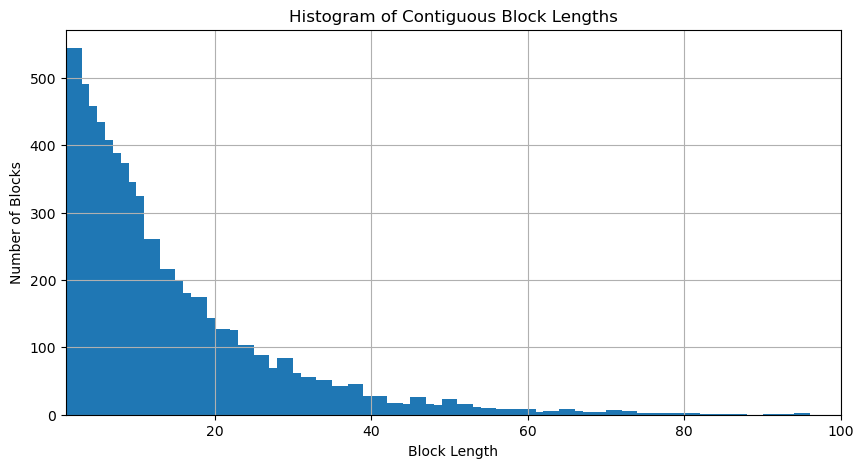

In [39]:
# 4) Plot histogram for blocks length 1–1000
plot_diff_histogram(block_stats, min_length=1, max_length=100, step=2)

### Con vari metodi riempimento (near,min,max,mean)

In [52]:
def resample_sensor(
    df_hard: DataFrame,
    sensor: str,
    interval: int = 60,
    method: str = "near"
) -> DataFrame:
    """
    Resample a single sensor column to regular intervals.

    Args:
      df_hard:   DataFrame with 'when' (in seconds) and the sensor column.
      sensor:    name of the sensor column (e.g. 'S117').
      interval:  interval in seconds (e.g. 60).
      method:    one of 'near', 'min', 'max', 'mean'.

    Returns:
      DataFrame with columns ['when', sensor, 'time'] at regular timestamps.
      All values are non-null. If no data is found for a window, the row is skipped.
    """
    spark = df_hard.sparkSession
    half = interval / 2

    # Validate method
    if method not in ("near", "min", "max", "mean"):
        raise ValueError(f"Unsupported method '{method}'. Choose from 'near', 'min', 'max', 'mean'.")

    # 1. Create time grid
    bounds = df_hard.selectExpr("min(when) as min_t", "max(when) as max_t").first()
    min_t, max_t = bounds.min_t, bounds.max_t

    grid_df = (
        spark.range(1)
             .selectExpr(f"sequence({min_t}, {max_t}, {interval}) as times")
             .select(explode("times").alias("target_when"))
    )

    # 2. Join with range ± half interval and exclude NULLs before aggregation
    filtered = df_hard.select("when", sensor).filter(col(sensor).isNotNull())

    joined = (
        filtered
          .join(
              grid_df,
              (col("when") >= col("target_when") - half) &
              (col("when") <= col("target_when") + half),
              how="inner"
          )
          .withColumn("time_diff", spark_abs(col("when") - col("target_when")))
    )

    # 3. Aggregate based on method
    if method == "near":
        agg_expr = min_by(col(sensor), col("time_diff")).alias(sensor)
    elif method == "min":
        agg_expr = spark_min(col(sensor)).alias(sensor)
    elif method == "max":
        agg_expr = spark_max(col(sensor)).alias(sensor)
    else:  # mean
        agg_expr = spark_avg(col(sensor)).alias(sensor)

    result = (
        joined.groupBy("target_when")
              .agg(agg_expr)
    )

    # 4. Final formatting
    final = (
        result
          .withColumnRenamed("target_when", "when")
          .withColumn("time", from_unixtime(col("when")))
          .orderBy("when")
    )

    return final

In [106]:
# Nearest‐time fill
df_near = resample_sensor(df_hard, "S117", interval=60, method="near")
df_near.show(5)

# Minimum‐value fill
df_min = resample_sensor(df_hard, "S117", interval=60, method="min")
df_min.show(5)

# Maximum‐value fill
df_max = resample_sensor(df_hard, "S117", interval=60, method="max")
df_max.show(5)

# Mean‐value fill
df_mean = resample_sensor(df_hard, "S117", interval=60, method="mean")
df_mean.show(5)

# Invalid method raises:
# resample_sensor(df_hard, "S117", 60, method="median")
# → ValueError: Unsupported method 'median'. Choose from 'near', 'min', 'max', 'mean'.

In [47]:
# PROVA MARCO VECCHIA CONVERSIONE SENSORI A5 A9, ricopiata il codice può essere utile
# --- OCCHIO --- questo ti pare che faccia la conversione del binario da dx verso sx, dovrebbe essere il contrario

# def convert_a5_to_binary_bits(df,sensor):
#     df_with_bits = df
    
#     for i in range(16):
#         bit_position = 15 - i  # S1 = bit 15 (leftmost), S16 = bit 0 (rightmost)
#         df_with_bits = df_with_bits.withColumn(
#             f"YOLO{i+1}",
#             (  col(sensor).bitwiseAND(1 << bit_position)  > 0 ).cast("int")
#         )
    
#     return df_with_bits

# # Usage
# df_with_binary = convert_a5_to_binary_bits(df_pivoted,"A5")

### Anomaly detection (Prova Marco sarà da cancellare)

In [40]:
def detect_switch_anomaly(df, sensor, window_minutes=10, switch_threshold=5):
    """
    Detects frequent switching for binary sensor, partitioned by day to avoid single-node pressure.
    """

    # Extract day (or hour) from timestamp to partition
    df = df.withColumn("day", to_date(from_unixtime(col("when"))))

    # Lag to get previous value within each partition --- OTHERWISE IT MOVES ALL IN THE SAME PARTITION
    w_lag = Window.partitionBy("day").orderBy("when")
    df_lagged = df.withColumn("prev", lag(col(sensor)).over(w_lag))

    # Detect change 0→1 or 1→0
    df_changes = df_lagged.withColumn(
        "change", when((col("prev") != col(sensor)), 1).otherwise(0)
    )

    # Rolling window over time with partition
    w_time = Window.partitionBy("day").orderBy("when").rangeBetween(-window_minutes * 60, 0)
    df_windowed = df_changes.withColumn(
        "change_count", sum_("change").over(w_time)
    )

    # Flag anomaly
    df_anomaly = df_windowed.withColumn(
        "is_anomaly", (col("change_count") > switch_threshold)
    ).drop("prev", "change", "change_count", "day")

    return df_anomaly

In [41]:
df_anom = detect_switch_anomaly(
  df_resampled_S117,
  sensor="S117",
  window_minutes=60,
  switch_threshold=6
)
df_anom.filter("is_anomaly").show()

25/07/29 13:22:17 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/07/29 13:22:35 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 13:22:54 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 13:22:54 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 13:22:54 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 13:22:55 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


+----------+----+-------------------+----------+
|      when|S117|               time|is_anomaly|
+----------+----+-------------------+----------+
|1602882502|   1|2020-10-16 21:08:22|      true|
|1602882562|   1|2020-10-16 21:09:22|      true|
|1602882622|   1|2020-10-16 21:10:22|      true|
|1602882742|   0|2020-10-16 21:12:22|      true|
|1602882802|   0|2020-10-16 21:13:22|      true|
|1602882862|   0|2020-10-16 21:14:22|      true|
|1602882922|   0|2020-10-16 21:15:22|      true|
|1602932722|   1|2020-10-17 11:05:22|      true|
|1602932782|   1|2020-10-17 11:06:22|      true|
|1602932842|   1|2020-10-17 11:07:22|      true|
|1602932902|   0|2020-10-17 11:08:22|      true|
|1602932962|   0|2020-10-17 11:09:22|      true|
|1602933022|   0|2020-10-17 11:10:22|      true|
|1602933082|   0|2020-10-17 11:11:22|      true|
|1602933142|   0|2020-10-17 11:12:22|      true|
|1602933202|   0|2020-10-17 11:13:22|      true|
|1602933262|   0|2020-10-17 11:14:22|      true|
|1602933322|   0|202

In [42]:
ini = 1602882742-50*60

In [43]:
fine =1602882742+50*60

In [44]:
inspect(df_resampled_S117, sensors=["S117"], start=ini, end=fine).show(100)

25/07/29 13:22:55 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/07/29 13:23:12 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


+-------------------+----------+----+
|               time|      when|S117|
+-------------------+----------+----+
|2020-10-16 20:22:22|1602879742|   0|
|2020-10-16 20:23:22|1602879802|   0|
|2020-10-16 20:24:22|1602879862|   0|
|2020-10-16 20:25:22|1602879922|   0|
|2020-10-16 20:26:22|1602879982|   0|
|2020-10-16 20:27:22|1602880042|   0|
|2020-10-16 20:28:22|1602880102|   1|
|2020-10-16 20:29:22|1602880162|   1|
|2020-10-16 20:30:22|1602880222|   1|
|2020-10-16 20:31:22|1602880282|   1|
|2020-10-16 20:32:22|1602880342|   0|
|2020-10-16 20:33:22|1602880402|   0|
|2020-10-16 20:34:22|1602880462|   0|
|2020-10-16 20:35:22|1602880522|   0|
|2020-10-16 20:36:22|1602880582|   0|
|2020-10-16 20:37:22|1602880642|   0|
|2020-10-16 20:38:22|1602880702|   0|
|2020-10-16 20:39:22|1602880762|   0|
|2020-10-16 20:40:22|1602880822|   0|
|2020-10-16 20:41:22|1602880882|   0|
|2020-10-16 20:42:22|1602880942|   0|
|2020-10-16 20:43:22|1602881002|   0|
|2020-10-16 20:44:22|1602881062|   0|
|2020-10-16 

25/07/29 13:23:13 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
                                                                                

# Predictive Maintenance

# *** Remember to close Spark Session ***

In [45]:
spark.stop()